Необходимо разработать модель машинного обучения для прогнозирования связывающей способности малых молекул с определенными белками, что поможет разработке лекарств для фармацевтической промышленности. Необходимо предсказать, какие лекарственно-подобные малые молекулы (химические вещества) будут связываться с тремя возможными белками (HSA, sEH, BRD4).

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 36.6 MB/s eta 0:00:00


In [ ]:
!pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 62.4 MB/s eta 0:00:00


**Разведочный анализ (EDA)**

Всего в тренировочной базе данных 295 246 830 наблюдений, 1 589 906 (0.54%) из них по казывают, что химические соединения связываются с одним из трех белков.

Как будет показано ниже, в базе данных есть формулы целой молекулы (столбец molecule_smiles), а также трех "концов" молекулы, которые непосредственно соединяются с белками (столбцы buildingblock1_smiles, buildingblock2_smiles, buildingblock3_smiles).

Рассмотрим подробнее целевую переменную и имеющиеся "окончания" молекул. Выгрузим случайную выборку из 200 тыс. наблюдений - половину для положительной целевой переменной, половину - для отрицательной.




In [ ]:
import duckdb
import pandas as pd

#pd.set_option('max_columns', None)

train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 100000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 100000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,186613264,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,CS(=O)(=O)c1ccc(N)cc1F,CC(C)(C)NS(=O)(=O)c1cccc(N)c1,CC(C)(C)NS(=O)(=O)c1cccc(Nc2nc(Nc3ccc(S(C)(=O)...,HSA,0
1,142627925,O=C(Nc1c(C(=O)O)cnn1CCO)OCC1c2ccccc2-c2ccccc21,Nc1cccnc1F,CC1(C)CC(CN)C(C)(C)O1,CC1(C)CC(CNc2nc(Nc3cccnc3F)nc(Nc3c(C(=O)N[Dy])...,sEH,0
2,139157862,O=C(Nc1c(C(=O)O)ccc2ccccc12)OCC1c2ccccc2-c2ccc...,NCc1c[nH]c2ccccc12,Cc1cnc(N)s1,Cc1cnc(Nc2nc(NCc3c[nH]c4ccccc34)nc(Nc3c(C(=O)N...,BRD4,0
3,218561522,O=C(Nc1ccnc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Cl.NCc1nc(-c2ccco2)n[nH]1,NCc1nccs1,O=C(N[Dy])c1cc(Nc2nc(NCc3nc(-c4ccco4)n[nH]3)nc...,sEH,0
4,152554680,O=C(Nc1c(I)c(C(=O)O)c(I)c(C(=O)O)c1I)OCC1c2ccc...,CC(C)(C)OC(=O)N1Cc2c(N)n[nH]c2C1(C)C,COc1nc(C)ccc1CN,COc1nc(C)ccc1CNc1nc(Nc2n[nH]c3c2CN(C(=O)OC(C)(...,BRD4,0


In [ ]:
%%time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder


# buildingblock1_smiles, ...
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# Generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    morgan_fp_gen = rdFingerprintGenerator.GetMorganGenerator(includeChirality=True, radius=radius, fpSize=bits) #, useCountSimulation=False)
    return list(morgan_fp_gen.GetFingerprint(molecule))


df['ecfp'] = df['molecule'].apply(generate_ecfp)

CPU times: user 6min 33s, sys: 9.84 s, total: 6min 43s
Wall time: 6min 43s


In [ ]:
import matplotlib.pyplot as plt
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,186613264,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,CS(=O)(=O)c1ccc(N)cc1F,CC(C)(C)NS(=O)(=O)c1cccc(N)c1,CC(C)(C)NS(=O)(=O)c1cccc(Nc2nc(Nc3ccc(S(C)(=O)...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x7e9a523b8ac0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,142627925,O=C(Nc1c(C(=O)O)cnn1CCO)OCC1c2ccccc2-c2ccccc21,Nc1cccnc1F,CC1(C)CC(CN)C(C)(C)O1,CC1(C)CC(CNc2nc(Nc3cccnc3F)nc(Nc3c(C(=O)N[Dy])...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x7e9a523b9230>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,139157862,O=C(Nc1c(C(=O)O)ccc2ccccc12)OCC1c2ccccc2-c2ccc...,NCc1c[nH]c2ccccc12,Cc1cnc(N)s1,Cc1cnc(Nc2nc(NCc3c[nH]c4ccccc34)nc(Nc3c(C(=O)N...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x7e9a523bad50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,218561522,O=C(Nc1ccnc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Cl.NCc1nc(-c2ccco2)n[nH]1,NCc1nccs1,O=C(N[Dy])c1cc(Nc2nc(NCc3nc(-c4ccco4)n[nH]3)nc...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x7e9a523badc0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,152554680,O=C(Nc1c(I)c(C(=O)O)c(I)c(C(=O)O)c1I)OCC1c2ccc...,CC(C)(C)OC(=O)N1Cc2c(N)n[nH]c2C1(C)C,COc1nc(C)ccc1CN,COc1nc(C)ccc1CNc1nc(Nc2n[nH]c3c2CN(C(=O)OC(C)(...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x7e9a523bae30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Рассмотрим целевую переменную.

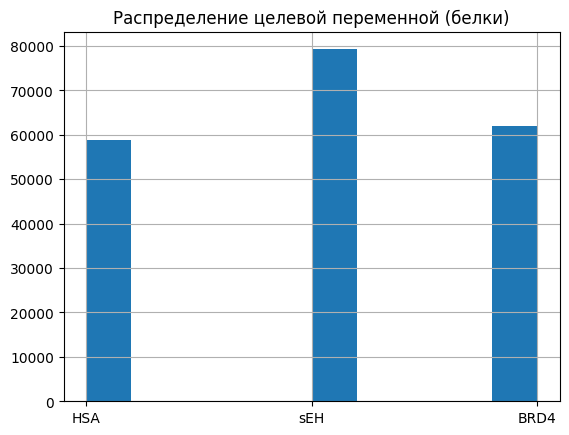

In [ ]:
import matplotlib.pyplot as plt
df['protein_name'].hist()
plt.title('Распределение целевой переменной (белки)');

Три "целевых" белка распределены достаточно равномерно. Больше всего белка sEH, немного меньше - HSA и BRD4.

Посмотрим на "концы" молекул (переменные buildingblock1_smiles, buildingblock2_smiles, buildingblock3_smiles), которые соединяются с белками. Отдельно блок 1:

In [ ]:
df_aggr = df.groupby(by=['buildingblock1_smiles']).agg({'id': ['count']})
df_aggr.columns = ['id']
df_aggr = df_aggr.reset_index()
df_aggr

,buildingblock1_smiles,id
0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,521
1,C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,504
2,C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,423
3,C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,500
4,C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,576
...,...,...
266,O=C(O)[C@H]1CCN1C(=O)OCC1c2ccccc2-c2ccccc21,528
267,O=C(O)[C@H]1COCCN1C(=O)OCC1c2ccccc2-c2ccccc21,490
268,O=C(O)[C@H]1C[C@H](O)CN1C(=O)OCC1c2ccccc2-c2cc...,558
269,O=C(O)[C@H]1Cc2ccccc2CN1C(=O)OCC1c2ccccc2-c2cc...,478


In [ ]:
df_aggr['id'].median()

594.0

Всего мы видим 270 уникальных видов окончания молекул. Медианная встречаемость каждого типа - 594.

Рассмотрим блок 2:

In [ ]:
df_aggr2 = df.groupby(by=['buildingblock2_smiles']).agg({'id': ['count']})
df_aggr2.columns = ['id']
df_aggr2 = df_aggr2.reset_index()
df_aggr2

,buildingblock2_smiles,id
0,C#CCOc1ccc(CN)cc1.Cl,210
1,C#CCOc1cccc(CN)c1.Cl,313
2,C#Cc1ccc(N)cc1,358
3,C#Cc1cccc(N)c1,244
4,C=C(C)C(=O)NCCN.Cl,80
...,...,...
688,Nc1ncnc2c1ncn2C1CCCCO1,70
689,Nc1ncncc1Br,376
690,Nc1nnc(S)s1,149
691,Nc1nncs1,774


In [ ]:
df_aggr2 = df.groupby(by=['buildingblock2_smiles']).agg({'id': ['count']})
df_aggr2.columns = ['id']
df_aggr2 = df_aggr2.reset_index()
df_aggr2

,buildingblock2_smiles,id
0,C#CCOc1ccc(CN)cc1.Cl,210
1,C#CCOc1cccc(CN)c1.Cl,313
2,C#Cc1ccc(N)cc1,358
3,C#Cc1cccc(N)c1,244
4,C=C(C)C(=O)NCCN.Cl,80
...,...,...
688,Nc1ncnc2c1ncn2C1CCCCO1,70
689,Nc1ncncc1Br,376
690,Nc1nnc(S)s1,149
691,Nc1nncs1,774


In [ ]:
df_aggr2['id'].median()

244.0

Во втором блоке 692 уникальных значения. В среднем (медианный показатель) около 244 раз встречается каждый тип в базе данных.

Блок 3:

In [ ]:
df_aggr3 = df.groupby(by=['buildingblock3_smiles']).agg({'id': ['count']})
df_aggr3.columns = ['id']
df_aggr3 = df_aggr3.reset_index()
df_aggr3

,buildingblock3_smiles,id
0,Br.Br.NCC1CCCN1c1cccnn1,525
1,Br.NCc1cccc(Br)n1,592
2,C#CCOc1ccc(CN)cc1.Cl,165
3,C#CCOc1cccc(CN)c1.Cl,109
4,C#Cc1ccc(N)cc1,40
...,...,...
865,Nc1ncncc1Br,12
866,Nc1nnc(S)s1,252
867,Nc1nncs1,281
868,Nc1nnn[nH]1,746


In [ ]:
df_aggr3['id'].median()

194.5

В третьем блоке 869 уникальных значения.

Такой большой обьем наблюдений (миллионы), который есть в базе данных, трудно обработать, поэтому загрузим только часть данных - по 200 000 наблюдений для каждого белка, выбранных случайным образом. Половина из них будет с таргетом 0 (соединения нет), половина - с таргетом 1 (соединение есть). Для каждого из трех белков (HSA, sEH, BRD4) построим свою модель.

**Белок HSA**

In [ ]:
#protein HSA

import duckdb
import pandas as pd


train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0 AND protein_name='HSA'
                        ORDER BY random()
                        LIMIT 100000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1 AND protein_name='HSA'
                        ORDER BY random()
                        LIMIT 100000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,269790811,O=C(O)C[C@H](Cc1ccc(F)cc1)NC(=O)OCC1c2ccccc2-c...,Cn1ncc2cc(N)ccc21,CC(C)c1nc(N)sc1Br,CC(C)c1nc(Nc2nc(Nc3ccc4c(cnn4C)c3)nc(N[C@H](CC...,HSA,0
1,107216476,O=C(N[C@@H](Cc1ccsc1)C(=O)O)OCC1c2ccccc2-c2ccc...,Cc1sc(N)c(C#N)c1C,Cl.NCCN1C(=O)SC(=Cc2cccs2)C1=O,Cc1sc(Nc2nc(NCCN3C(=O)SC(=Cc4cccs4)C3=O)nc(N[C...,HSA,0
2,122974909,O=C(N[C@H](Cc1ccc(Cl)cc1)C(=O)O)OCC1c2ccccc2-c...,Nc1ccc2c(c1)CNCC2,Nc1ccc(Cl)cc1F,O=C(N[Dy])[C@@H](Cc1ccc(Cl)cc1)Nc1nc(Nc2ccc3c(...,HSA,0
3,38002264,COc1ccc([C@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Nc1ccc2c(c1)COC2=O,CN1CC(CN)CC1=O,COc1ccc([C@H](Nc2nc(NCC3CC(=O)N(C)C3)nc(Nc3ccc...,HSA,0
4,164396305,O=C(Nc1cc(C(=O)O)ccc1Br)OCC1c2ccccc2-c2ccccc21,Nc1cccc(-n2cncn2)c1,N#Cc1c[nH]nc1N,N#Cc1c[nH]nc1Nc1nc(Nc2cccc(-n3cncn3)c2)nc(Nc2c...,HSA,0


Так как химические формулы соединений записаны буквами, представим их в числовом виде. Для этого воспользуемся библиотекой Chem. В результате перекодировки получается разреженная матрица, представленная в виде 0 и 1.

In [ ]:
%%time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder


df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)


def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    morgan_fp_gen = rdFingerprintGenerator.GetMorganGenerator(includeChirality=True, radius=radius, fpSize=bits)
    return list(morgan_fp_gen.GetFingerprint(molecule))


df['ecfp'] = df['molecule'].apply(generate_ecfp)

CPU times: user 5min 38s, sys: 7.17 s, total: 5min 45s
Wall time: 5min 46s


In [ ]:
%%time

RANDOM_STATE=12345

X = df['ecfp'].tolist()
y = df['binds'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

CPU times: user 149 ms, sys: 4.99 ms, total: 154 ms
Wall time: 155 ms


In [ ]:
len(X_train)

160000

Лучшую эффективность на метрике f1 показала модель XGBClassifier. Подберем оптимальные параметры с помощью RandomizedSearchCV.

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

xgb_model = RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE), param_distributions={
    'n_estimators': range(10, 400),
    'learning_rate': [0.01, 0.05],
    'subsample': [0.3, 0.9],
    'max_depth': range(2, 15),
    'colsample_bytree': [0.4, 0.5],
    'min_child_weight': range(1, 10)
}, scoring='f1', random_state=RANDOM_STATE, cv=5)

xgb_model_fit = xgb_model.fit(X_train, y_train)
xgb_model_rmse = xgb_model_fit.best_score_

print('f1, xgb1:', abs(xgb_model_rmse))
print('Оптимальные значения параметров:', xgb_model_fit.best_params_)

f1, xgb1: 0.8675313153848553
Оптимальные значения параметров: {'subsample': 0.3, 'n_estimators': 238, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
CPU times: user 4h 30min, sys: 1min 29s, total: 4h 31min 29s
Wall time: 1h 46min 52s


**Белок sEH**

 Сделаем те же преобразования для белка sEH.

In [ ]:
%%time

#protein sEH

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0 AND protein_name='sEH'
                        ORDER BY random()
                        LIMIT 100000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1 AND protein_name='sEH'
                        ORDER BY random()
                        LIMIT 100000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 2min 29s, sys: 15.7 s, total: 2min 45s
Wall time: 1min 1s


In [ ]:
%%time

df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df['ecfp'] = df['molecule'].apply(generate_ecfp)

CPU times: user 5min 33s, sys: 4.1 s, total: 5min 37s
Wall time: 5min 37s


In [ ]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,121091438,O=C(N[C@H](Cc1ccc(Cl)c(Cl)c1)C(=O)O)OCC1c2cccc...,CNC(=O)c1cc(Oc2ccc(N)cc2)ccn1,Cl.NCC12CC3CC(CC(C3)C1)C2,CNC(=O)c1cc(Oc2ccc(Nc3nc(NCC45CC6CC(CC(C6)C4)C...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e922d50>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,113242058,O=C(N[C@H](C(=O)O)C1CCCC1)OCC1c2ccccc2-c2ccccc21,Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1,COc1cncc(N)c1,COc1cncc(Nc2nc(Nc3nc(-c4cccc([N+](=O)[O-])c4)c...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e922ce0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,169517018,O=C(Nc1cc(Cl)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cl.NCc1cccc2cc[nH]c12,Cc1cc(N)n[nH]1,Cc1cc(Nc2nc(NCc3cccc4cc[nH]c34)nc(Nc3cc(Cl)ccc...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e922c70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,187452530,O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,CC(CN)c1c(Cl)cccc1Cl,N#Cc1c(N)sc2c1CCCC2,CC(CNc1nc(Nc2ccc(C(=O)N[Dy])cc2)nc(Nc2sc3c(c2C...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e922c00>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,149006306,O=C(Nc1c(F)cc(Br)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1c2ccccc2nc2ccccc12,Cl.NCc1nnc2ncccn12,O=C(N[Dy])c1cc(Br)cc(F)c1Nc1nc(NCc2nnc3ncccn23...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e922b90>,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
%%time

X2 = df['ecfp'].tolist()
y2 = df['binds'].tolist()

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=RANDOM_STATE)

CPU times: user 146 ms, sys: 5 ms, total: 151 ms
Wall time: 150 ms


In [ ]:
%%time

xgb_model2 = RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE), param_distributions={
    'n_estimators': range(10, 400),
    'learning_rate': [0.01, 0.05],
    'subsample': [0.3, 0.9],
    'max_depth': range(2, 15),
    'colsample_bytree': [0.4, 0.5],
    'min_child_weight': range(1, 10)
}, scoring='f1', random_state=RANDOM_STATE, cv=5)

xgb_model_fit2 = xgb_model2.fit(X2_train, y2_train)
xgb_model_rmse2 = xgb_model_fit2.best_score_

print('f1, xgb2:', abs(xgb_model_rmse2))
print('Оптимальные значения параметров:', xgb_model_fit2.best_params_)

f1, xgb2: 0.9661108516031319
Оптимальные значения параметров: {'subsample': 0.3, 'n_estimators': 238, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
CPU times: user 4h 23min 24s, sys: 1min 24s, total: 4h 24min 49s
Wall time: 1h 45min 5s


**Белок BRD4**

In [ ]:
%%time

#protein BRD4

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0 AND protein_name='BRD4'
                        ORDER BY random()
                        LIMIT 100000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1 AND protein_name='BRD4'
                        ORDER BY random()
                        LIMIT 100000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 2min 27s, sys: 12.1 s, total: 2min 40s
Wall time: 41.7 s


In [ ]:
%%time

df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df['ecfp'] = df['molecule'].apply(generate_ecfp)

CPU times: user 5min 53s, sys: 17.5 s, total: 6min 10s
Wall time: 6min 11s


In [ ]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,110331171,O=C(N[C@@H]1CC[C@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,COc1ncc(N)cc1C(F)(F)F,Cc1cc(CN)c(C)s1,COc1ncc(Nc2nc(NCc3cc(C)sc3C)nc(N[C@@H]3CC[C@H]...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e98eb20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,254805894,O=C(O)C[C@@H](Cc1cccs1)NC(=O)OCC1c2ccccc2-c2cc...,Nc1ccc2c(c1)CNCC2,NCc1cnns1,O=C(C[C@@H](Cc1cccs1)Nc1nc(NCc2cnns2)nc(Nc2ccc...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x78b33e98ec70>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,40515147,COc1nccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,COC(C)(CN)C1CC1,Cl.NCC(=O)NC1CCC1,COc1nccc(C(=O)N[Dy])c1Nc1nc(NCC(=O)NC2CCC2)nc(...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x78b2e6ebb450>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,178292508,O=C(Nc1cc([N+](=O)[O-])ccc1C(=O)O)OCC1c2ccccc2...,N#Cc1ccc(N)c([N+](=O)[O-])c1,COc1ccc(CN)c(C)c1OC,COc1ccc(CNc2nc(Nc3cc([N+](=O)[O-])ccc3C(=O)N[D...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x78b2e6ebb4c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,92273424,O=C(N[C@@H](Cc1cc(F)c(F)c(F)c1)C(=O)O)OCC1c2cc...,NCCC1CSC1,CC(C)c1nc(N)sc1Br,CC(C)c1nc(Nc2nc(NCCC3CSC3)nc(N[C@@H](Cc3cc(F)c...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x78b2e6ebb530>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
%%time

X3 = df['ecfp'].tolist()
y3 = df['binds'].tolist()

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=RANDOM_STATE)

CPU times: user 154 ms, sys: 3.99 ms, total: 158 ms
Wall time: 157 ms


In [ ]:
%%time

xgb_model3 = RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE), param_distributions={
    'n_estimators': range(10, 400),
    'learning_rate': [0.01, 0.05],
    'subsample': [0.3, 0.9],
    'max_depth': range(2, 15),
    'colsample_bytree': [0.4, 0.5],
    'min_child_weight': range(1, 10)
}, scoring='f1', random_state=RANDOM_STATE, cv=5)

xgb_model_fit3 = xgb_model3.fit(X3_train, y3_train)
xgb_model_rmse3 = xgb_model_fit3.best_score_

print('f1, xgb3:', abs(xgb_model_rmse3))
print('Оптимальные значения параметров:', xgb_model_fit3.best_params_)

f1, xgb3: 0.9275279606523575
Оптимальные значения параметров: {'subsample': 0.3, 'n_estimators': 238, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
CPU times: user 4h 34min 45s, sys: 1min 21s, total: 4h 36min 6s
Wall time: 1h 47min 46s


**Тестовая выборка**

В тестовом наборе данных 1,67 млн. наблюдений. Будем загружать их порциями по 100 тыс. наблюдений. Для каждого белка используем свою модель. В качестве предсказания возьмем вероятность соединения с этим белком.

In [ ]:
%%time
import os



test_file = '/kaggle/input/leash-BELKA/test.csv'
output_file = 'submission.csv'

def probabilities_final(row):

    protein = row['protein_name']

    if protein == 'HSA':
        return row['HSA']
    elif protein == 'sEH':
        return row['sEH']
    elif protein == 'BRD4':
        return row['BRD4']
    else:
        return 0


for df_test in pd.read_csv(test_file, chunksize=100000):


    df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
    df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)


    X_test = df_test['ecfp'].tolist()


    df_test['HSA'] = xgb_model.predict_proba(X_test)[:, 1]
    df_test['sEH'] = xgb_model2.predict_proba(X_test)[:, 1]
    df_test['BRD4'] = xgb_model3.predict_proba(X_test)[:, 1]

    df_test['binds'] =  df_test.apply(probabilities_final, axis=1)


    output_df = pd.DataFrame({'id': df_test['id'], 'binds': df_test['binds']})


    output_df.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))

CPU times: user 1h 3s, sys: 23.6 s, total: 1h 27s
Wall time: 57min 57s


**Вывод:** Объем тренировочных данных очень велик (больше 296 млн. наблюдений), для построения модели использовалась только часть данных.

Удалось улучшить метрику на тестовой выборке с базовой, равной 0.259, до 0.335. Показатели улучшило увеличение кол-ва наблюденний, на которых строились модели. А также использование трех моделей для каждого белка вместо мультиклассовой одной модели. Было использовано несколько моделей, но лучше всего себя показал XGBClassifier, который использовался в финальных расчетах.